Dada a equação de Poisson em 2D:

\begin{equation*}
  \begin{cases}
    \nabla^2 U = 0 &\text{ para } \Omega\\
    U = 0 &\text{ para } \partial\Omega_{A, B, C}\\
    U = sen(2 \pi x) &\text{ para } \partial\Omega_{D}
  \end{cases}
\end{equation*}

Temos a seguinte condição de controno de Dirichlet $u= \alpha $

Usando aproximação discreta do MDF de segunda ordem, com convergência O(h²), temos que problema de Poisson 2D fica organizado da seguinte maneira em forma de sistema linear:

\begin{equation*}
  \frac{(u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4u_{i,j})}{h^2} = f_{i,j}
\end{equation*}

Por exemplo na aproximação do ponto (1) é aplicada nos ppontos adjacentes ao contorno, deve-se mover os pontos correspondentes para o lado direito da equação, $i=j=1$:

\begin{equation*}
   -4u_{1,1} + u_{2,1} + u_{1,2} = h^2f_{1,1} - u_{0,1} - u_{1,0}
\end{equation*}

Assim basta descobrir os pontos internos fora do contorno(já conhecidos), partindo daqueles adjacentes ao contorno, para os posteriores, utilizando os resultantes obtidos passo-a-passo.

Montando assim o sistema $AU = f$, obtemos, o seguinte modelo:

\begin{equation*}
  \begin{bmatrix}
    \begin{bmatrix}
      -4 & 1 & 0 \\
      1 & -4 & 1 \\
      0 & 1 & -4 \\
    \end{bmatrix} & \begin{bmatrix}
      1 & 0 & 0 \\
      0 & 1 & 0 \\
      0 & 0 & 1 \\
    \end{bmatrix} & \begin{bmatrix}
      0 & 0 & 0 \\
      0 & 0 & 0 \\
      0 & 0 & 0 \\
    \end{bmatrix} \\
      \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0 \\
        0 & 0 & 1 \\
    \end{bmatrix} & \begin{bmatrix}
      -4 & 1 & 0 \\
      1 & -4 & 1 \\
      0 & 1 & -4 \\
    \end{bmatrix}  & \begin{bmatrix}
      1 & 0 & 0 \\
      0 & 1 & 0 \\
      0 & 0 & 1 \\
    \end{bmatrix}
  \end{bmatrix}
  \begin{bmatrix}
    u_{1,1} \\
    u_{2,1} \\
    u_{3,1} \\
    u_{1,2} \\
    u_{2,2} \\
    ... \\
    u_{3,3} \\
  \end{bmatrix} = h^2 \begin{bmatrix}
    f_{1,1} \\
    f_{2,1} \\
    f_{3,1} \\
    f_{1,2} \\
    f_{2,2} \\
    ... \\
    f_{3,2} \\
    \end{bmatrix} + \begin{bmatrix}
    u_{1,0} + u_{0,1} \\
    u_{2,0} \\
    u_{3,0} + u_{-4,1}\\
    u_{0,2} \\
    0 \\
    u_{4,2} \\
  \end{bmatrix}
\end{equation*}

Temos que de modo geral

Onde B é a matriz tridiagonal M x M:

\begin{equation*}
  \begin{bmatrix}
    1 \\
    1 & -4 & 1 \\
     & 1 & -4 & 1\\
     & ... & ... & ...\\
     &  & 1 & -4 & 1\\
     & & & & 1\\
  \end{bmatrix}
\end{equation*}

E assim obtemos a matriz A, que é M² x M²:

\begin{equation*}
  \begin{bmatrix}
    I \\
    -I^* & B & -I^* \\
     & -I^* & B & -I^*\\
     & ... & ... & ...\\
     &  & -I^* & B & -I^*\\
     & & & & I\\
  \end{bmatrix}
\end{equation*}

O vetor F, é organizado da seguinte maneira:

\begin{equation*}
  \begin{bmatrix}
    \alpha_0/h^2 \\
    f_1 + \alpha_1/h^2 \\
    f_2 + \alpha_2/h^2 \\
     ...\\
    f_{M-2} + \alpha_{M-2}/h^2 \\
    f_{M-1} + \alpha_{M-1}/h^2 \\
    \alpha_M/h^2 \\
  \end{bmatrix}
\end{equation*}

In [134]:
%%writefile pivoteamento.h
#ifndef PIVOTEAMENTO_H
#define PIVOTEAMENTO_H

void substituicaoSucess(float *A, float *F, int *p, int n, float *x);
void substituicaoRetroa(float *A, float *F, float *x, int *p, int n);
void montaPLU(float *A, float *F, float *u, int n, int *p);
void salvaMatriz2D(float *matriz, int n, const string& arquivo);
void salvaMatriz(float *matriz, int n, const string& arquivoName);

#endif //PIVOTEAMENTO_H

Overwriting pivoteamento.h


In [141]:
%%writefile pivoteamento.cpp
#include <iostream>
using namespace std;
#include <fstream>
#include <vector>
#include <math.h>
#include <string>
#include <chrono>
#include "matrizes.h"

void salvaMatriz(float *mat, int n, const string& arquivoName) {
    // Matriz que vai receber os valores dos tecidos
    vector<float> matriz;

    // Inicializar a matriz que vai ser salva com elementos
    matriz.resize(n);
    for (int i = 0; i < n; i++) {
      matriz[i] =  mat[i];
    }

    // Salvar a matriz de tecidos em um arquivo para ser importada posteriormente
    ofstream arquivo(arquivoName);
    if (arquivo.is_open()) {
      for (const auto& linha : matriz) {
        arquivo << linha << " ";
      }
      arquivo.close();
      cout << endl;
      cout << "C++: Matriz solucao salva em " << arquivoName << endl;
    } else {
      cerr << "C++: Erro ao abrir o arquivo" << endl;
    }
}

void salvaMatriz2D(float *mat, int n, const string& arquivo) {
    ofstream arquivoSaida(arquivo);
    if (arquivoSaida.is_open()) {
        for (int i = 0; i < n; i++) {
            for (int j = 0; j < n; j++) {
                arquivoSaida << mat[i * n + j] << " ";
            }
            arquivoSaida << endl;  // Pular para a próxima linha no arquivo
        }
        arquivoSaida.close();
        cout << endl;
        cout << "Matriz solução salva em " << arquivo << endl;
    } else {
        cerr << "Erro ao abrir o arquivo" << endl;
    }
}

//SUBSTITUICAO SUCESSIVA Lx = pF
void substituicaoSucess(float *A, float *F, int *p, int n, float *x) {
  for(int k=0; k<n; k++) {
    x[k] = F[p[k]];

    for(int j=0; j<k; j++) {
      x[k] = x[k] - A[detInd(p[k],j,n)]*x[j];
    }
    x[k] = x[k]/1.0; //pode retirar
  }

  cout << endl;
  cout << endl;
  cout << endl;
  cout << "Matriz y: " << endl;
  for(int i=0; i<n; i++) {
    cout << x[i] << " ";
  }
}

//SUBSTITUICAO RETROATIVA Ux = F
void substituicaoRetroa(float *A, float *F, float *x, int *p, int n) {
  auto start = chrono::high_resolution_clock::now();

  for(int k=n; k>=0; k--) {

    for(int j=k+1; j<n; j++) {
      x[k] = x[k] -A[detInd(p[k],j,n)]*x[j];
    }
    x[k] = x[k]/A[detInd(p[k],k,n)];

  }

  cout << endl;
  cout << endl;
  cout << endl;
  cout << "Matriz solucao: " << endl;
  for(int i=0; i<n; i++) {
    cout << x[i] << " ";
  }

  salvaMatriz2D(x,sqrt(n),"solucao.txt");

  auto stop = chrono::high_resolution_clock::now();
  auto duration = chrono::duration_cast<chrono::milliseconds>(stop - start);

  cout << endl;
  cout << "Tempo pra realizar a retrosubstituicao: " << duration.count() << " milliseconds" << endl;
}


void montaPLU(float *A, float *F, float *u, int n, int *p) {
  auto start = chrono::high_resolution_clock::now();

  for(int k=0; k<n; k++) {
    //ENCONTRAR PIVOS DE A
    float max = fabs(A[detInd(p[k],k,n)]);
    int iMax = k;

    for(int i=k+1; i<n; i++) {
      if(max<fabs(A[detInd(p[i],k,n)])) {
        max = fabs(A[detInd(p[i],k,n)]);
        iMax = i;
      }
      //cout << endl;
      //cout << endl;
      //cout << endl;
      //cout << "Maior pivo: " << max << endl;
    }
    //cout << "Indice: " << iMax << endl;

    int tmp = p[k];
    p[k] = p[iMax];
    p[iMax] = tmp;

    //anular elementos
    for(int i=k+1; i<n; i++) {
      float m = A[detInd(p[i],k,n)]/A[detInd(p[k],k,n)];
      //F[i] = F[p[k]] - F[p[i]];
      A[detInd(p[i],k,n)] = m;
      for(int j=k+1; j<n; j++) {
        A[detInd(p[i],j,n)] = A[detInd(p[i],j,n)] - (m*A[detInd(p[k],j,n)]);
      }

    }
  }


  /*cout << endl;
  cout << endl;
  cout << endl;
  cout << "Matriz A(LU): " << endl;
  for(int i=0; i<n; i++) {
    for(int j=0; j<n; j++) {
      cout << A[detInd(p[i],j,n)] << ", ";
    }
    cout << endl;
  }*/

  auto stop = chrono::high_resolution_clock::now();
  auto duration = chrono::duration_cast<chrono::milliseconds>(stop - start);

  cout << endl;
  cout << "Tempo para montar matriz PLU: " << duration.count() << " milliseconds" << endl;
}

Overwriting pivoteamento.cpp


In [136]:
%%writefile matrizes.h
#ifndef MATRIZES_H
#define MATRIZES_H

int detInd(int i, int j, int m);
float seno(float x);
void montaSubMatrizes(float *princ, float *sec, int m);
void montaMatrizResultante(float *A, float *princ, float *sec, int m);
void montaF(float *F, int m, int ua, int ub, int uc, float ud, float h);

#endif //MATRIZES_H

Overwriting matrizes.h


In [137]:
%%writefile matrizes.cpp
#include <iostream>
using namespace std;
#include <fstream>
#include <vector>
#include <math.h>
#include <string>
#include <chrono>

#include "pivoteamento.h"

int detInd(int i, int j, int m) {
  return (i < m && j < m) ? i*m + j : -1;
}

float seno(float x) {
  return sin(2* M_PI * x);
}

void montaSubMatrizes(float *princ, float *sec, int m) {
  for(int i=1; i<m-1; i++) {
    for(int j=0; j<m; j++) {
      princ[detInd(i, j, m)] = i==j ? -4 : (i+1==j || j+1==i) ? 1 : 0;
      sec[detInd(i, j, m)] = i==j ? 1 : 0;
    }
  }

  princ[detInd(0, 0, m)] = 1;
  princ[detInd(m-1, m-1, m)] = 1;


  //cout << "MATRIZ DIAGONAL PRINCIPAL: " << endl;
  //for(int i=0; i<m; i++) {
  //  for(int j=0; j<m; j++) {
  //    cout << princ[detInd(i, j, m)] << " ";
  //  }
  //  cout << endl;
  //}

  cout << endl;
  cout << endl;

  //cout << "MATRIZ DIAGONAL SECUNDARIA: " << endl;
  //for(int i=0; i<m; i++) {
  //  for(int j=0; j<m; j++) {
  //    cout << sec[detInd(i, j, m)] << " ";
  //  }
  //  cout << endl;
  //}

  cout << endl;
  cout << endl;
}


void montaMatrizResultante(float *A, float *princ, float *sec, int m) {
  auto start = chrono::high_resolution_clock::now();
  //Produto de Kronecker I X T
  for(int l=1; l<m-1; l++) {
    for(int k=0; k<m; k++) {
      for(int i=0; i<m; i++) {
        for(int j=0; j<m; j++) {
          A[detInd(l*m + i, k*m + j, m*m)] = (l == k) ? sec[detInd(l,k,m)] * princ[detInd(i,j,m)] : (l+1 == k || k+1 == l) ? sec[detInd(i,j,m)] : 0;
        }
      }
    }
  }

  //completa primeiro elemento da matriz com a identidade
  for(int i=0; i<m; i++) {
    for(int j=0; j<m; j++) {
      A[detInd(i,j,m*m)] = (i==j) ? 1 : 0;
    }
  }

  //completa ultimo elemento da matriz com a identidade
  for(int i=m*m-m; i<m*m; i++) {
    for(int j=m*m-m; j<m*m; j++) {
      A[detInd(i,j,m*m)] = (i==j) ? 1 : 0;
    }
  }

  //cout << "MATRIZ A: " << endl;
  //for(int i=0; i<m*m; i++) {
  //  for(int j=0; j<m*m; j++) {
  //      cout << A[detInd(i,j,m*m)] << " ";
  //  }
  //  cout << endl;
  //}

  cout << endl;
  cout << endl;

  auto stop = chrono::high_resolution_clock::now();
  auto duration = chrono::duration_cast<chrono::milliseconds>(stop - start);

  cout << endl;
  cout << "Tempo para produto de Kronecker: " << duration.count() << " milliseconds" << endl;
  salvaMatriz2D(A,m,"matA.txt");
}


void montaF(float *F, int m, int ua, int ub, int uc, float ud, float h) {
  for(int i=0; i<m; i++) {
    for(int j=0; j<m; j++) {
      ud = -seno(h*detInd(i,j,m));
      F[detInd(i,j,m)] = (i==0 && j==0) ? ua + ub : (j==m-1 && i==0) ? ub + uc : (i==m-1 && j==m-1) ? uc + ud : (i==m-1 && j==0) ? ua + ud : (j==0) ? ua : (i==0) ? ub : (j==m-1) ? uc : (i==m-1) ? ud : 0;
    }
  }

  salvaMatriz(F,m,"matF.txt");

  //cout << "MATRIZ F: " << endl;
  //for(int i=0; i<m; i++) {
  //  for(int j=0; j<m; j++) {
  //    cout << F[detInd(i,j,m)] << " ";
  //  }
  //  cout << endl;
  //}
}

Overwriting matrizes.cpp


In [157]:
%%writefile main.cpp
#include <iostream>
using namespace std;
#include <string>
#include <cmath>
#include <chrono>

#include "matrizes.h"
#include "pivoteamento.h"

int main()
{
    //CONDICOES DO PROBLEMA
    float h = 0.05; //refinamento da malha
    int n = 21; //tamanho do sistema n x n
    //condicoes de contorno
    int ua = 0; //esquerda
    int ub = 0; //topo
    int uc = 0; //direita
    float ud = sin(2*M_PI); //base -> vai ser alterada na funcao de montar F para sen(2*pi*x)

    //ESTRUTURACAO DO PROBLEMA COM MATRIZES E SOLUCAO
    float *princ = new float[n*n]; //matriz da diagonal principal para montar A
    float *sec = new float[n*n]; //matriz da diagonal secundaria para montar A
    float *A = new float[static_cast<int>(pow(n, 4))]; //matriz A
    float *F = new float[n*n]; //matriz F
    float *u = new float[n*n]; //vetor solucao
    int *p = new int[(n*n)]; //vetor para pivoteamento

    for(int i=0; i<n*n; i++) {
      p[i] = i;
    }

    float *x = new float[n*n];

    //for(int i=0; i<n*n; i++) {
    //  x[i] = 0;
    //}

    auto start = chrono::high_resolution_clock::now();

    montaSubMatrizes(princ, sec, n);
    montaMatrizResultante(A, princ, sec, n);
    montaF(F, n, ua, ub, uc, ud, h);
    montaPLU(A, F, u, n*n, p); //decomposicao LU
    substituicaoSucess(A, F, p, n*n, x); //substituicao
    substituicaoRetroa(A, F, x, p, n*n); //retrosubstituicao com resultado

    auto stop = chrono::high_resolution_clock::now();
    auto duration = chrono::duration_cast<chrono::milliseconds>(stop - start);

    cout << endl;
    cout << "Tempo total: " << duration.count() << " milliseconds" << endl;

    return 0;
}

Overwriting main.cpp


In [158]:
!g++ matrizes.cpp \
  pivoteamento.cpp \
  main.cpp \
  -o poisson2d

In [159]:
!./poisson2d








Tempo para produto de Kronecker: 2 milliseconds

Matriz solução salva em matA.txt

C++: Matriz solucao salva em matF.txt

Tempo para montar matriz PLU: 482 milliseconds



Matriz y: 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

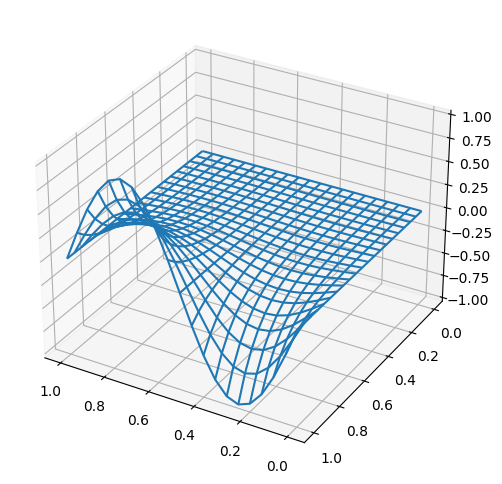

In [160]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import math

from google.colab import files
from matplotlib.figure import projections

plt.rcParams['figure.figsize'] = [8, 6]

h=0.05;
x = np.arange(0, 1+h/2, h)
y = np.arange(0, 1+h/2, h)
x, y = np.meshgrid(x, y)

# carregar a matriz do arquivo
resultados = np.loadtxt('solucao.txt')

# matA = np.loadtxt('matA.txt')
# matF = np.loadtxt('matF.txt')

# try:
#     inversa = np.linalg.inv(matA)
#     print("A matriz matA é invertível.")
# except np.linalg.LinAlgError:
#     print("A matriz matA não é invertível.")
# resultados = np.linalg.solve(matA, matF)

# print(resultados)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(x, y, resultados)
ax.invert_xaxis()
ax.invert_yaxis()
plt.show()

Verifique se a matriz não é singular, ou seja, se possui inversa. Você pode verificar isso calculando o determinante da matriz ou verificando se a matriz é mal condicionada - Isso ta dando errado